Import libraries and MNIST dataset

In [287]:
# Includes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes from MNIST are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes from MNIST are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


Regroup data in low digits (0...5) and high (6..9)

**NELLO SCRIPT SOTTO MI PARE CHE QUESTA PARTE NON LA USO**

In [318]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]
img_rows, img_cols = 28, 28

trainLow_samples = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples  = np.sum(np.where(label_test  < 6, 1, 0))

# separate in containers data that is lower and higer than 6
# TRAIN - LOW
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
#       - HIGH
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

# TEST - LOW
data_low_test   = np.zeros([testLow_samples,28,28])
label_low_test  = np.zeros(testLow_samples)

#      - HIGH
data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
label_high_test = np.zeros(test_samples-testLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1


j,k = 0,0
for i in range(0,test_samples):
    if(label_test[i]>5):
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        k+=1  
    else:
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        j+=1

# Reshape
data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# Print
print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

# Normalize the colors from 0-255 to 0-1
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28, 1)
     Train dataset higher than 6 has shape: (23983, 28, 28, 1)

     Test dataset lower than 6 has shape:  (6031, 28, 28, 1)
     Test dataset higher than 6 has shape: (3969, 28, 28, 1)


Load Frozen model (Features model) and features for the pre-trained data

In [288]:
features = np.loadtxt('Models/Original_model/ll_features_10.txt')
labels_features = np.loadtxt('Models/Original_model/ll_labels_features_10.txt')
labels_features = labels_features.astype(int)
model = keras.models.load_model('Models/Original_model/mnist_cnn.h5') # Frozen model 

# Print
# model.summary()
# Features_model.summary()

Features_model = keras.models.Sequential(model.layers[:-1])  # extract the last layer from the original model
Features_model.compile()

# Kmeans 

## Fit initial dataset - Sklearn Kmeans

In [289]:
# Fit initial dataset. First we need to extract the corresponding images from the features list

# Define initial set of features
labels_init_list = list([1, 9, 5, 0])
# labels_init_list = list([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

# Initialize features and labels arrays for 
labels_init = []
features_init = []

for i in range(0, len(features)):
      if labels_features[i] in labels_init_list:
        features_init.append(features[i,:])
        labels_init.append(labels_features[i])

# debug
print(np.shape(features_init))
print(np.shape(features))

# Fit initial dataset using n clusters
n_clust_init = len(labels_init_list)

Kmeans = KMeans(n_clusters = n_clust_init)
Kmeans.fit(features_init)

# Kmean.cluster_centers_ -> Centroidi
# Kmeans.cluster_centers_.shape
# print("True labels",labels_init)
# print("Pseudo labels", Kmeans.labels_)

(40, 512)
(100, 512)


KMeans(n_clusters=4)

### Confusion Matrix

In [290]:
# 1: map labels to rows
# [1, 9, 5, 0]

fake_labels_init = []
for lbl in labels_init:
    fake_labels_init.append(labels_init_list.index(lbl))

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cmtx = confusion_matrix(fake_labels_init, Kmeans.labels_)
print(cmtx)

# Map true-labels to clusters
map_idx = np.argmax(cmtx, axis = 1)  

# confusion_matrix.shape

# Fill dictionary with map
map_clu2lbl = {}
map_lbl2clu = {}
for i in range(0, len(map_idx)):
    map_clu2lbl[map_idx[i]] = labels_init_list[i]
    map_lbl2clu[labels_init_list[i]] = map_idx[i]

map_clu2lbl # cluster: label
map_lbl2clu # label: cluster

[[ 0 10  0  0]
 [ 0  0  0 10]
 [ 0  0  9  1]
 [ 8  0  0  2]]


{1: 1, 9: 3, 5: 2, 0: 0}

## Calcolo features dei nuovi dati
Uso il Features_model
e (data_train, label_train),(data_test, label_test)

In [293]:
# Assegno i centroidi iniziali e calcolo le varianze dei cluster

# Initialize dictionary used to store images related to each cluster
# clu_images = dict.fromkeys(range(0, n_clust_init), [])
# creates dictionary using dictionary comprehension -> list [] is mutable object
clu_images = { key : [] for key in range(0, n_clust_init) }

for i in range(0, len(features_init)):
    lbl = map_lbl2clu[labels_init[i]] # Label expressed as cluster index
    clu_images[lbl].append(features_init[i])

### DATA STREAM
data_stream = data_train

BATCH_SIZE = 1 # Lo script da qui funzionerebbe anche con batch 


# Processing one image at a time
idx = 99 # Simulate image capture

img = data_stream[idx].reshape(BATCH_SIZE, 28, 28, 1)    
img_features = Features_model.predict(img)              

# Compute prediction using distance from clusters
dist = Kmeans.transform(img_features)                   
print("Distances from clusters", dist)
img_cluster = np.argmin(dist, axis = 1)


# Compute sum of square differences of each cluster (wrt centroid)
clu_ctr = [Kmeans.cluster_centers_[i] for i in range(0,n_clust_init)] # Previous cluster centroids
clu_2dar = [np.stack(clu_images[i], axis=0) for i in range(0,n_clust_init)]

### agg nuove immagini

# calcolo posiz nuovi centroidi usando mean()
# ...

from numpy.linalg import norm

clu_ssd = np.zeros([n_clust_init, 512])
clu_ssd2 = np.zeros([n_clust_init, 1])

for i in range(0, n_clust_init):
    diff = np.zeros([clu_2dar[i].shape[0], 512])
    for j in range(0, clu_2dar[i].shape[0]): 
        diff[j,:] = (clu_2dar[i][j,:] - clu_ctr[i])**2
    clu_ssd[i,:] = diff.sum(axis = 0)
    clu_ssd2[i] = np.linalg.norm(clu_ssd[i,:])

       
        # print(diff.shape)

#  sum[(x - c)^2]
np.zeros([1, n_clust_init])

print(clu_2dar[3].shape) # elementi del clusrer 3

print(clu_ssd.shape)

print(clu_ctr[i].shape)
print(clu_2dar[i][j,:].shape)
print(clu_ssd2)



############


1/1 [==============================] - 0s 26ms/step
Distances from clusters [[4928.77195689 4921.31362824 4929.70733464 4927.12120149]]
(10, 512)
(4, 512)
(512,)
(512,)
[[217.51643417]
 [125.72828746]
 [272.47641846]
 [217.96260568]]


In [95]:

# cluster 0
CLU_TMP = 0
# seleziono immagini in cluster 0

# Seleziono immagini con label "cluster 0"
img_cluster = {}

for i in range(0, len(features_init)):
    pass

print(len(features))
lbls_idx = list(np.where(np.array(lbls) == CLU_TMP)[0])   # Equivalente ma con Numpy
# lbls_idx = [i for i in range(len(lbls)) if lbls[i] == CLU_TMP]
out = np.array(features_init)[lbls_idx]

# print(np.array(features_init))

print(np.array(features_init).shape)
# features_init[lbls_idx][1]
list1 = [0, 10, 20, 30, 40, 50, 60]
ar1 = np.array(list1)
# ar1[[2, 4]]
# list1[[2, 4]]
#features_init[0].shape
#features_init[0][1]

SyntaxError: expected ':' (499178354.py, line 35)

In [257]:
good_lbl = 0
bad_lbl = 0
NA_lbl = 0

In [317]:
# Assegno i centroidi iniziali e calcolo le varianze dei cluster
# centroids = {}
# variances = {}
# for i in range(n_clust_init):
#     centroids[i] = Kmeans.cluster_centers_[i]
#    variances[i] = 0 


good_lbl = 0
bad_lbl = 0
NA_lbl = 0


    
# Array that simulates the data stream from the OPENMV
data_stream = data_train

BATCH_SIZE =  1# Lo script da qui funzionerebbe anche con batch 

# Processing one image at a time
good_lbl = 0
bad_lbl = 0

for idx in range(0,10):

    img = data_stream[idx].reshape(BATCH_SIZE, 28, 28, 1)    
    img_features = Features_model.predict(img, verbose  = 0)              

    # Compute prediction using distance from clusters
    dist = Kmeans.transform(img_features)  
    scr = Kmeans.score(img_features.astype(float))      

    img_cluster = np.argmin(dist, axis = 1)

    
    max1 = np.max(dist, axis = 1) 
    min1 =  np.min(dist, axis = 1)

    # score1 = (max1 - min1)/min1
    score1 = (max1/min1 - 1)*1000

    print("Distances", dist, "Score", score1, "Lbl:", map_clu2lbl[img_cluster[0]], "True:", label_train[idx])
    
    #print("Scores from clusters", scr)

    # if img_cluster < 6000

    ### --- works only with single image
    # print("Predicted label for image is: ", map_clu2lbl[img_cluster[0]], "[Cluster {:d}]".format(img_cluster[0]))

    # Plot the input
    #fig = plt.figure
    #img_plt = img.reshape(28, 28)
    #plt.imshow(img_plt, cmap='gray')
    #plt.show()

    #print("Label",lbl,  "True label", label_train[idx])


    lbl = map_clu2lbl[img_cluster[0]]
    if lbl == label_train[idx]:
        good_lbl += 1
    else:
        if label_train[idx] not in labels_init_list:
            NA_lbl += 1
        else: 
            bad_lbl += 1

# print("GOOD:", good_lbl,"BAD:", bad_lbl,"NA:", NA_lbl)


Distances [[6225.05311363 6226.88918742 6217.22287184 6225.18346138]] Score [1.55476421] Lbl: 5 True: 5
Distances [[6545.71455436 6557.99986744 6555.36390042 6554.4206871 ]] Score [1.87684828] Lbl: 0 True: 0
Distances [[6853.10059074 6853.02669616 6850.52652728 6851.03768954]] Score [0.37574681] Lbl: 5 True: 4
Distances [[5491.06598265 5487.18682184 5492.72108844 5490.79835338]] Score [1.00857995] Lbl: 1 True: 1
Distances [[7375.01288406 7374.42651434 7373.31359933 7369.73472458]] Score [0.71619396] Lbl: 9 True: 9
Distances [[7166.30915222 7170.68163565 7168.30614504 7166.92502294]] Score [0.6101444] Lbl: 0 True: 2
Distances [[6376.07428806 6364.26320922 6375.87455055 6375.2275457 ]] Score [1.85584387] Lbl: 1 True: 1
Distances [[7906.19525235 7908.69481223 7900.35795055 7903.36368018]] Score [1.05525113] Lbl: 5 True: 3
Distances [[6035.68412194 6024.16389369 6035.61175911 6035.35137416]] Score [1.91233646] Lbl: 1 True: 1
Distances [[8559.03085101 8558.70769714 8556.61312642 8555.858731

In [270]:
2 not in labels_init_list


True

In [ ]:
# Compute metrics 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

print(img_features.shape)

# Funziona solo comparando diversi samples..
#silhouette_score(img_features, centroids)
#calinski_harabasz_score(img_features, img_cluster)
#davies_bouldin_score(img_features, )

In [231]:
# Compute variance

# Compute sum of square differences of each cluster (wrt centroid)
clu_ctr = [Kmeans.cluster_centers_[i] for i in range(0,n_clust_init)] # Previous cluster centroids


## AGG LAA NUOVA IMMAGINE

# img_cluster[0] è il cluster identificato
# clu_images[1].append(img_features)
clu_images[img_cluster[0]][0] = img_features.tolist()[0] # sostituisco primaa img nel cluster con la nuova
clu_2dar = [np.stack(clu_images[i], axis=0) for i in range(0,n_clust_init)]

# calcolo posiz nuovi centroidi usando mean()
# ...

from numpy.linalg import norm

clu_ssd = np.zeros([n_clust_init, 512])
clu_ssd2 = np.zeros([n_clust_init, 1])

for i in range(0, n_clust_init):
    diff = np.zeros([clu_2dar[i].shape[0], 512])
    for j in range(0, clu_2dar[i].shape[0]): 
        diff[j,:] = (clu_2dar[i][j,:] - clu_ctr[i])
    clu_ssd[i,:] = diff.sum(axis = 0)
    clu_ssd2[i] = np.linalg.norm(clu_ssd[i,:])

clu_ssd2

array([[6.54147224e+03],
       [2.32503650e-14],
       [2.28822996e+01],
       [2.03412254e+01]])

In [230]:
# Reinizializzo i cluster
clu_images = { key : [] for key in range(0, n_clust_init) }

for i in range(0, len(features_init)):
    lbl = map_lbl2clu[labels_init[i]] # Label expressed as cluster index
    clu_images[lbl].append(features_init[i])

clu_2dar = [np.stack(clu_images[i], axis=0) for i in range(0,n_clust_init)]
clu_ssd = np.zeros([n_clust_init, 512])
clu_ssd2 = np.zeros([n_clust_init, 1])
for i in range(0, n_clust_init):
    diff = np.zeros([clu_2dar[i].shape[0], 512])
    for j in range(0, clu_2dar[i].shape[0]): 
        diff[j,:] = (clu_2dar[i][j,:] - clu_ctr[i])
    clu_ssd[i,:] = diff.sum(axis = 0)
    clu_ssd2[i] = np.linalg.norm(clu_ssd[i,:])
clu_ssd2

array([[1.93124657e-14],
       [2.32503650e-14],
       [2.28822996e+01],
       [2.03412254e+01]])

# TO DO LIST
Aggiorno i centroidi con i nuovi dati

1) prelevo la nuova immagine OK
2) Ne calcolo le features usando il frozen model OK
3) Capire a quale cluster l'immagine appartiene -> Predict OK
4) In base allo score:

      - Aggiorno il centroide con il nuovo dato -> settare il learning rate 
      - Creo un nuovo cluster con l'immagine nuova.

      OSS: vedere lo score se calcolarlo con dist o con score è meglio per settare la soglia, o usare altre metriche anche,, o l'inerzia (se riesco ad estrarmela dallaa classe)


**Da qui in poi bisogna capire come creare i nuovi cluster ed aggiungerli al Kmeans object**:
- o si esce dal SKlearn e si implementa "a mano da qui in poi il clustering sfruttando lo script sotto
- oppure si può magari fare un batch di tutti gli *outliers* e clusterizzarli assieme e vedere che succede...

## Codice funzionante fino a qui

In [170]:

# Variables
max_iter = 300
tol = 0.01



# Sposto i centroidi per ottimizzarli
for ii in range(max_iter):

    # Inizializzo i classificatori
    classifications = {}
    for i in range(n_clust_init):
        classifications[i] = []

    for featureset in data:
        distances = [np.linalg.norm(featureset - centroids[centroid]) for centroid in centroids]
        classification = distances.index(min(distances))        # retrieve index of cluster with smallest distance
        classifications[classification].append(featureset)

    prev_centroids = dict(centroids)


    for classification in classifications:
      centroids[classification] = np.average(classifications[classification], axis=0)

    optimized = True

    for c in centroids:
        original_centroid = prev_centroids[c]
        current_centroid = centroids[c]

        #print((current_centroid - original_centroid) / original_centroid)

        #if np.sum((current_centroid - original_centroid) / original_centroid * 100.0) > tol:
        #    print(np.sum((current_centroid - original_centroid) / original_centroid * 100.0))
    #        optimized = False

    if optimized:
        break

In [168]:
# Variables
max_iter = 300
tol = 0.01


data = features_init


# Sposto i centroidi per ottimizzarli
for ii in range(max_iter):

    # Inizializzo i classificatori
    classifications = {}
    for i in range(n_clust_init):
        classifications[i] = []

    for featureset in data:
        distances = [np.linalg.norm(featureset - centroids[centroid]) for centroid in centroids]
        classification = distances.index(min(distances))        # retrieve index of cluster with smallest distance
        classifications[classification].append(featureset)

    prev_centroids = dict(centroids)


    for classification in classifications:
      centroids[classification] = np.average(classifications[classification], axis=0)

    optimized = True

    for c in centroids:
        original_centroid = prev_centroids[c]
        current_centroid = centroids[c]

        #print((current_centroid - original_centroid) / original_centroid)

        #if np.sum((current_centroid - original_centroid) / original_centroid * 100.0) > tol:
        #    print(np.sum((current_centroid - original_centroid) / original_centroid * 100.0))
    #        optimized = False

    if optimized:
        break


print(centroids[0].shape)

#print(centroids[0])

#print(centroids[3])

print(np.array(classifications[0]).shape)
print(np.array(classifications[1]).shape)
print(np.array(classifications[2]).shape)
print(np.array(classifications[3]).shape)







(512,)
(2, 512)
(26, 512)
(11, 512)
(1, 512)


In [61]:




# Fit






class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self, data):

        # Initialize centroids with first data incoming

    def predict(self, data):
        distances = [np.linalg.norm(data - self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

    def update(self, new_data, delta):
        for featureset in new_data:
            distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]

            if min(distances) < delta:
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)
            else:
                self.centroids[self.k] = featureset
                self.classifications[self.k] = []
                self.classifications[self.k].append(featureset)
                self.k = self.k + 1






IndentationError: expected an indented block after function definition on line 14 (3852728260.py, line 18)

50.0
513.8888888888889
19.333333333333336
85.97370695537461


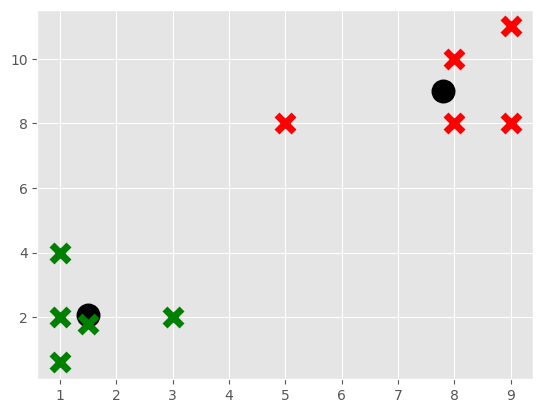

In [45]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')
colors = 10 * ["g", "r", "c", "b", "k"]

X = np.array([[1, 2],
              [1.5, 1.8],
              [5, 8],
              [8, 8],
              [8,10],
              [9,8],
              [3,2],
              [1,4],
              [1, 0.6],
              [9, 11]])

clf = K_Means(k = 2)
clf.fit(X)

X1 = np.array([[6, 8],
               [7, 10],
               [6, 4],
               [2, 2],
               [2, 3]])

#Updating the model with X1 and threshold of 4 
# clf.update(X1, 4)

for centroid in clf.centroids:
    plt.scatter(clf.centroids[centroid][0], clf.centroids[centroid][1],
                marker="o", color="k", s=150, linewidths=5)

for classification in clf.classifications:
    color = colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=color, s=150, linewidths=5)

plt.show()